### Import Necessary Library

In [17]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import davies_bouldin_score, silhouette_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

### Load Dataset

In [18]:
customers_df = pd.read_csv('Customers.csv')
transactions_df = pd.read_csv('Transactions.csv')
products_df = pd.read_csv('Products.csv')

#### Create feature matrix for clustering

In [19]:
def create_customer_features():
    # Customer transaction aggregates
    transaction_features = transactions_df.groupby('CustomerID').agg({
        'TransactionID': 'count',
        'TotalValue': ['sum', 'mean', 'std'],
        'Quantity': ['sum', 'mean']
    }).fillna(0)
    
    # Flatten column names
    transaction_features.columns = ['_'.join(col).strip() for col in transaction_features.columns.values]
    
    # Calculate category preferences
    trans_products = transactions_df.merge(products_df[['ProductID', 'Category']], on='ProductID')
    category_preferences = pd.crosstab(
        trans_products['CustomerID'], 
        trans_products['Category'],
        values=trans_products['TotalValue'],
        aggfunc='sum'
    ).fillna(0)
    
    # Calculate time-based features
    transactions_df['TransactionDate'] = pd.to_datetime(transactions_df['TransactionDate'])
    latest_transaction = transactions_df.groupby('CustomerID')['TransactionDate'].max()
    first_transaction = transactions_df.groupby('CustomerID')['TransactionDate'].min()
    
    time_features = pd.DataFrame({
        'recency': (pd.Timestamp.now() - latest_transaction).dt.days,
        'customer_age': (latest_transaction - first_transaction).dt.days
    })
    
    # Combine all features
    feature_matrix = pd.concat([
        transaction_features,
        category_preferences,
        time_features
    ], axis=1).fillna(0)
    
    return feature_matrix

#### Evaluate different numbers of clusters using DB Index and Silhouette Score

In [20]:
def evaluate_clusters(X, max_clusters=10):
    results = []
    
    for n_clusters in range(2, max_clusters + 1):
        kmeans = KMeans(n_clusters=n_clusters, random_state=42)
        labels = kmeans.fit_predict(X)
        
        db_index = davies_bouldin_score(X, labels)
        silhouette = silhouette_score(X, labels)
        
        results.append({
            'n_clusters': n_clusters,
            'db_index': db_index,
            'silhouette_score': silhouette
        })
    
    return pd.DataFrame(results)

#### Analyze characteristics of each cluster

In [25]:
def analyze_clusters(X, labels):
    X_with_labels = X.copy()
    X_with_labels['Cluster'] = labels
    
    cluster_stats = X_with_labels.groupby('Cluster').agg({
        'TransactionID_count': ['mean', 'std'],
        'TotalValue_sum': ['mean', 'std'],
        'Quantity_sum': ['mean', 'std'],
        'recency': ['mean', 'std']
    }).round(2)
    
    return cluster_stats

#### Create feature matrix()

In [26]:
print("Creating feature matrix...")
feature_matrix = create_customer_features()
# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(feature_matrix)

Creating feature matrix...


#### Evaluate different numbers of clusters

In [27]:
print("Evaluating cluster numbers...")
cluster_evaluation = evaluate_clusters(X_scaled)
print("\nClustering Metrics:")
print(cluster_evaluation)

Evaluating cluster numbers...

Clustering Metrics:
   n_clusters  db_index  silhouette_score
0           2  1.684787          0.207968
1           3  1.733536          0.182491
2           4  1.790890          0.154500
3           5  1.868252          0.152404
4           6  1.687577          0.154138
5           7  1.717223          0.145590
6           8  1.549271          0.156156
7           9  1.601509          0.154199
8          10  1.534746          0.153748


#### Select optimal number of clusters (lowest DB Index)

In [29]:
optimal_clusters = cluster_evaluation.loc[cluster_evaluation['db_index'].idxmin(), 'n_clusters']
print(f"\nOptimal number of clusters: {optimal_clusters}")


Optimal number of clusters: 10


#### Perform final clustering

In [30]:
final_kmeans = KMeans(n_clusters=int(optimal_clusters), random_state=42)
cluster_labels = final_kmeans.fit_predict(X_scaled)

### Visualization


Creating cluster visualization...


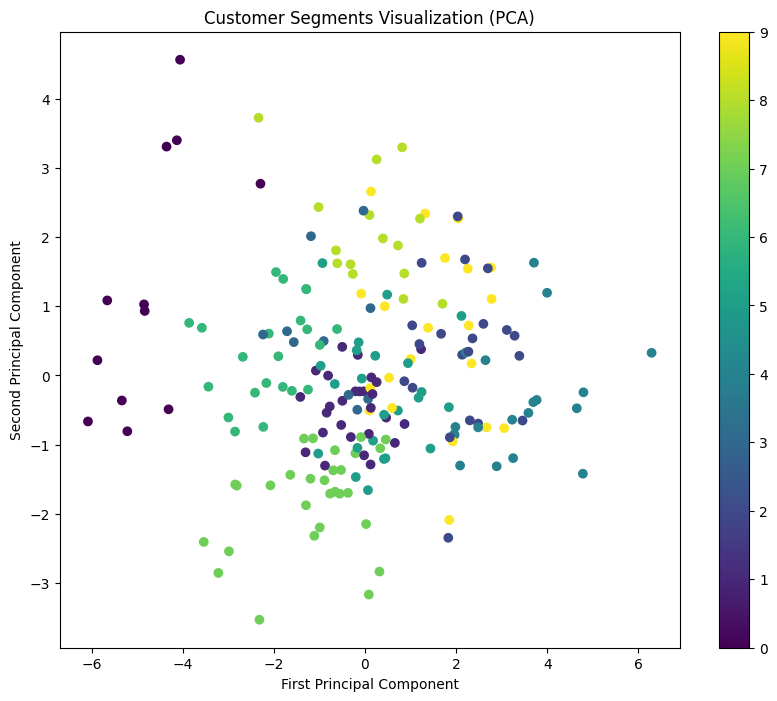

In [31]:
print("\nCreating cluster visualization...")
visualize_clusters(X_scaled, cluster_labels)

#### Analyze cluster characteristics

In [32]:
print("\nAnalyzing cluster characteristics...")
cluster_analysis = analyze_clusters(feature_matrix, cluster_labels)
print("\nCluster Statistics:")
print(cluster_analysis)


Analyzing cluster characteristics...

Cluster Statistics:
        TransactionID_count       TotalValue_sum          Quantity_sum        \
                       mean   std           mean      std         mean   std   
Cluster                                                                        
0                      1.25  0.62         662.94   549.72         2.92  2.39   
1                      4.44  0.93        2741.44   732.21        11.67  2.81   
2                      6.95  1.36        5244.14   838.36        19.81  2.99   
3                      3.10  1.29        2400.41   874.84         7.10  2.28   
4                      8.53  1.31        6549.21  1386.13        22.84  4.45   
5                      5.00  1.04        3516.60   867.28        12.09  2.47   
6                      3.00  0.87        1880.76   706.38         7.32  2.25   
7                      5.62  1.72        2382.84  1000.94        10.38  3.42   
8                      3.87  1.06        3761.31  1068.20    

In [33]:
results = {
    'optimal_clusters': int(optimal_clusters),
    'db_index': cluster_evaluation.loc[cluster_evaluation['db_index'].idxmin(), 'db_index'],
    'silhouette': cluster_evaluation.loc[cluster_evaluation['db_index'].idxmin(), 'silhouette_score']
}

In [37]:
print(f'Optimal Number of Clusters: {results["optimal_clusters"]}, '
      f'Davies-Bouldin Index: {results["db_index"]:.3f}, '
      f'Silhouette Score: {results["silhouette"]:.3f}')

Optimal Number of Clusters: 10, Davies-Bouldin Index: 1.535, Silhouette Score: 0.154
